<a href="https://colab.research.google.com/github/RyosukeHanaoka/TechTeacher_New/blob/main/detr_eval_mode_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!pip install fitz
!pip install pymupdf
!pip install pyheif

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.8/15.8 MB 68.3 MB/s eta 0:00:00


In [7]:
import os
from PIL import Image, ImageOps
import fitz  # PyMuPDF
import pyheif  # PyHEIF

# 必要なパスを設定
input_right_pre_path = '/content/drive/MyDrive/xpright_pre/'
input_left_pre_path = '/content/drive/MyDrive/xpleft_pre/'
output_right_path = '/content/drive/MyDrive/xpright/'
output_left_path = '/content/drive/MyDrive/xpleft/'

def convert_to_png(input_path, output_path):
    for img_name in os.listdir(input_path):
        img_path = os.path.join(input_path, img_name)
        base_name, ext = os.path.splitext(img_name)

        # 拡張子の正規化
        ext = ext.lower()

        # 出力ファイル名を設定
        output_file_name = f"{base_name}.png"
        output_file_path = os.path.join(output_path, output_file_name)

        if ext in ['.jpg', '.jpeg', '.png']:
            img = Image.open(img_path)
            img.save(output_file_path)

        elif ext == '.pdf':
            pdf_document = fitz.open(img_path)
            for page_num in range(pdf_document.page_count):
                page = pdf_document.load_page(page_num)
                pix = page.get_pixmap()
                img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
                page_output_path = os.path.join(output_path, f"{base_name}_page{page_num}.png")
                img.save(page_output_path)

        elif ext == '.heic':
            heif_file = pyheif.read(img_path)
            img = Image.frombytes(
                heif_file.mode,
                heif_file.size,
                heif_file.data,
                "raw",
                heif_file.mode,
                heif_file.stride,
            )
            img.save(output_file_path)

        else:
            print(f"Unsupported file format: {ext}")

# PNGに変換する
convert_to_png(input_right_pre_path, output_right_path)
convert_to_png(input_left_pre_path, output_left_path)

Using cache found in /root/.cache/torch/hub/facebookresearch_detr_main


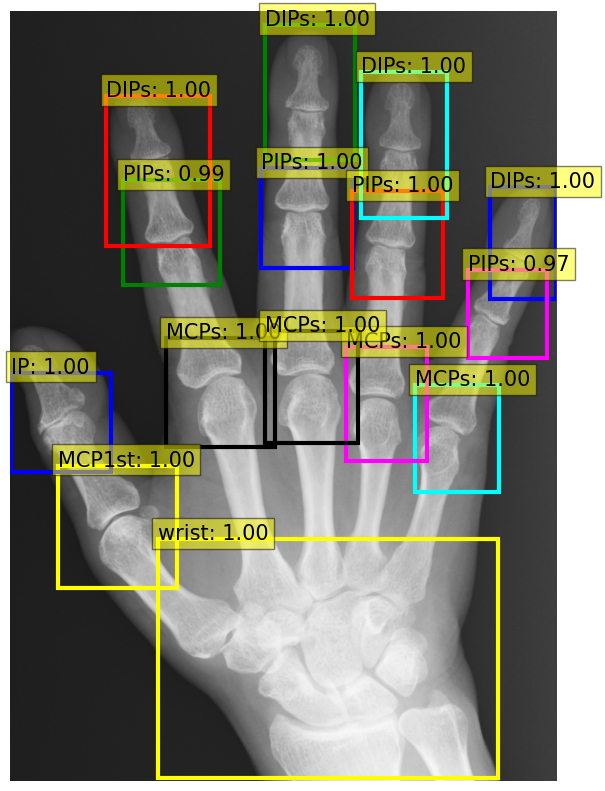

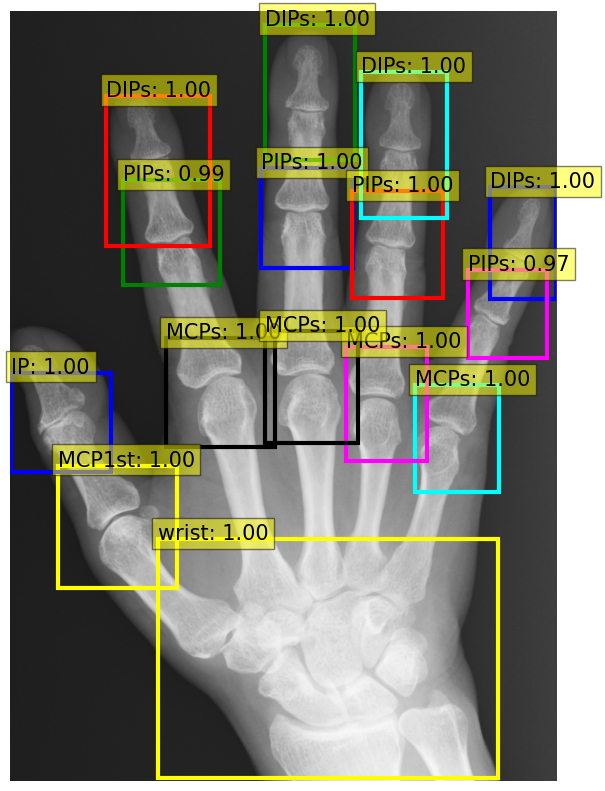

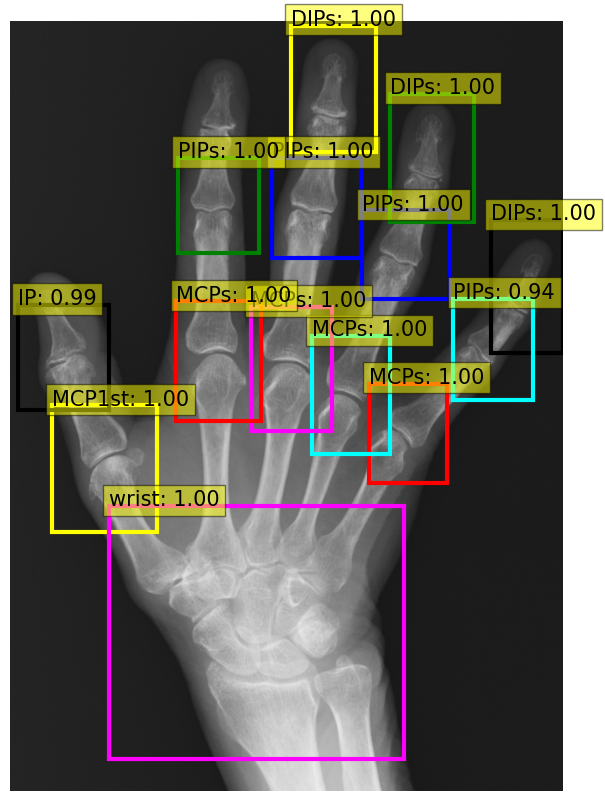

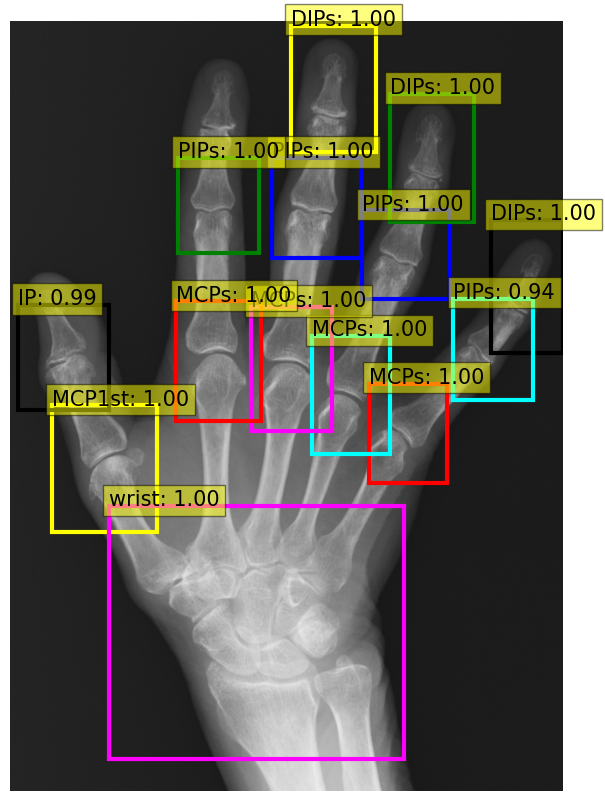

In [8]:
import torch
from torchvision import transforms as T
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import os

# 必要なパスを設定
input_right_path = '/content/drive/MyDrive/xpright/'
input_left_path = '/content/drive/MyDrive/xpleft/'
output_right_path = '/content/drive/MyDrive/xpright_post/'
output_left_path = '/content/drive/MyDrive/xpleft_post/'
output_right_cropped_path = '/content/drive/MyDrive/xpright_cropped/'
output_left_cropped_path = '/content/drive/MyDrive/xpleft_cropped/'

# チェックポイントのクラス数を確認
checkpoint_path = '/content/drive/MyDrive/detr/outputs/checkpoint.pth'
checkpoint = torch.load(checkpoint_path, map_location='cpu')
num_classes = checkpoint['model']['class_embed.weight'].shape[0]

# モデルのロード
model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=False, num_classes=7)
model.load_state_dict(checkpoint['model'], strict=False)
model.eval()

# カラーマップとクラス名の定義
COLORS = ["blue", "green", "red", "cyan", "magenta", "yellow", "black"]
finetuned_classes = ['N/A', 'wrist', 'MCP1st', 'MCPs', 'IP', 'PIPs', 'DIPs']

# 画像変換の定義
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
])

# バウンディングボックスの変換関数
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

# 結果の描画関数
def plot_results(pil_img, prob=None, boxes=None):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    if prob is not None and boxes is not None:
        for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
            ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                       fill=False, color=c, linewidth=3))
            cl = p.argmax()
            text = f'{finetuned_classes[cl]}: {p[cl]:0.2f}'
            ax.text(xmin, ymin, text, fontsize=15,
                    bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

def crop_and_save(img, boxes, classes, output_base_path, img_name):
    for idx, (box, cls) in enumerate(zip(boxes.tolist(), classes)):
        xmin, ymin, xmax, ymax = map(int, box)
        cropped_img = img.crop((xmin, ymin, xmax, ymax))
        class_name = finetuned_classes[cls.argmax()]

        # クラスごとのディレクトリを作成
        class_dir = os.path.join(output_base_path, class_name)
        os.makedirs(class_dir, exist_ok=True)

        # 画像を保存
        base_name, ext = os.path.splitext(img_name)
        if ext.lower() not in ['.jpg', '.jpeg', '.png']:
            ext = '.png'
        cropped_img.save(os.path.join(class_dir, f"{base_name}_{class_name}_{idx}{ext}"))

def run_workflow(my_image, my_model, output_base_path, img_name):
    if my_image.mode == 'L':
        my_image = my_image.convert('RGB')

    img = transform(my_image).unsqueeze(0)

    outputs = my_model(img)
    for threshold in [0.9, 0.7]:
        probas_to_keep, bboxes_scaled = filter_bboxes_from_outputs(outputs, my_image.size, threshold=threshold)
        plot_results(my_image, probas_to_keep, bboxes_scaled)
        crop_and_save(my_image, bboxes_scaled, probas_to_keep, output_base_path, img_name)

def filter_bboxes_from_outputs(outputs, image_size, threshold=0.7):
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > threshold

    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], image_size)
    return probas[keep], bboxes_scaled

# ファイルの読み込みと処理
def process_images(input_path, output_path, cropped_output_path, flip=False):
    for img_name in os.listdir(input_path):
        img_path = os.path.join(input_path, img_name)
        img = Image.open(img_path)

        if flip:
            img = ImageOps.mirror(img)

        run_workflow(img, model, cropped_output_path, img_name)

        # ファイル名の拡張子を修正して保存
        base_name, ext = os.path.splitext(img_name)
        if ext.lower() not in ['.jpg', '.jpeg', '.png']:
            ext = '.png'
        img.save(os.path.join(output_path, base_name + ext))

# 右手と左手の画像を処理
process_images(input_right_path, output_right_path, output_right_cropped_path, flip=False)
process_images(input_left_path, output_left_path, output_left_cropped_path, flip=True)
